The notebook has been shared with permission of the Course convenor for COMP5318 (Machine learning and data mining) at the University of Sydney. Reproducing code here for other assignments/courses at the University of Sydney will be considered plagiarism.

This work was completed with one other student. 

### Constraints


For this assignment, we were constrained to using simple machine learning methods to classify a subset of the fashion MNIST data set (still 10 classes with a reduced number of samples). 

Simple here meaning no GPU accelerated methods, and based on the first 6 weeks of the course: linear and logistic regression, decision trees, ensemble methods, and support vector machines (i.e. no deep learning methods). The task was to test at least three models and report the best.

# COMP5318 Assignment 1 Semester 2 2021

In this notebook, not all cells have been run as some snippets were run on different hardware across multiple notebooks, and then combined here. The hardware for each section has been specified, otherwise assume the code was run on Colab using a standard CPU runtime.

#  Training the best model in under 10 minutes
To preprocess the data, train, and evaluate the best model in under 10 minutes. Simply run all the cells beneath the <font color = "red">red headings</font>. Other sections for exploratory analysis or hyper parameter tuning are marked by <font color = "blue"> blue headings </font>. 

# <font color = "red"> 1. Imports/Software Used </font>

The following software libraries were used in this study:

In [78]:
import h5py
import numpy as np
import os
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import multiprocessing
import seaborn as sns
sns.set_style('whitegrid')

# <font color = "red"> 2. Loading the Data </font>

## Training Data

In [2]:
print(os.listdir('./Input/train'))
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

print(data_train.shape,label_train.shape)

['images_training.h5', 'labels_training.h5']
(30000, 784) (30000,)


In [3]:
data_train.shape

(30000, 784)

In [4]:
data_train[0].shape

(784,)

## Validation Set

As directed in the assignment specification, 10-fold cross-validation will be utilised. These folds will be created at the time of training for each model, with a random seed set to ensure that all models are trained on the same 10-folds. Furthermore, the folds will be stratified to account for any differences in the representation of classes in the training data. 

## Testing Data

We need to get the first 2000 samples of the test set to use for internal model comparison. This set will not be used during training, and all models will only evaluated once on the test set of 2000 samples. The best model according to this sample of 2000 images will then be used to make predictions on the full test set of 5000 examples. These predictions will be submitted for external marking.

In [5]:
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])
print(data_test.shape,label_test.shape)

(5000, 784) (2000,)


# <font color = "blue"> 3. Exploring the Data and Pre-Processing Analysis </font>


First, we create a mapping from the class number to the actual item:

In [6]:
classNames = {0: "T-shirt/Top", 
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"}

To see what the data looks like, we plot some images with their labels:

In [7]:
data_train_plot = data_train.reshape((data_train.shape[0], 28, 28))

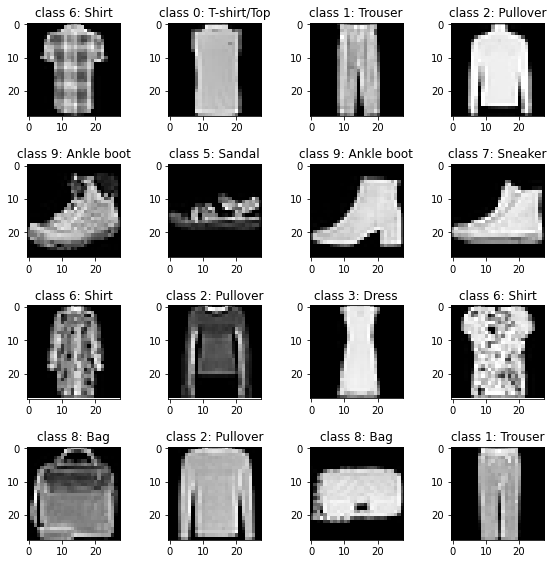

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(8,8))
fig.tight_layout()
i = 0
for ax in axs:
    for a in ax:
        a.imshow(data_train_plot[i], cmap=plt.get_cmap('gray'))
        plotTitle = f"class {str(label_train[i])}: {str(classNames[label_train[i]])}"
        a.set_title(plotTitle)
        i += 1

All items appear to be centered, although there is variation in the brightness/darkness of each item. Normalising the pixel values should resolve this issue. 

It also appears that some items are not labelled correctly, for example, it is unclear whether the item in column 1 row 3 is a shirt or a dress. Similarly, two pullovers are shown (row 1 column 4, and row 3 column 2), yet they appear to show different clothing items. Thus some of the examples may be mislabelled. 

## Descriptive Statistics

In [9]:
#Converting to dataframes for data exploration
def descriptiveStatsFn(data, labels):
    
    df_train = pd.DataFrame(data)
    df_train_label = pd.DataFrame(labels)
    train_stats = df_train.describe()
    train_is_null = df_train.isnull().values.any()
    train_label_dist = df_train_label.groupby(0).size()
    print("The training dataset has {} instances and {} attributes. There are {} labels".format(data.shape[0],data.shape[1], labels.shape))
    print("Descriptive Statistics\n{}\n".format(train_stats))
    print("Any null values?\n{}\n".format(train_is_null))
    print("Class Distribution\n{}".format(train_label_dist))
    
descriptiveStatsFn(data_train, label_train)

The training dataset has 30000 instances and 784 attributes. There are (30000,) labels
Descriptive Statistics
                0             1             2             3             4    \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       0.000003      0.000021      0.000099      0.000401      0.000927   
std        0.000324      0.000983      0.001995      0.009988      0.016992   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.054902      0.141176      0.203922      0.611765      0.878431   

                5             6             7             8             9    \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean       0.001391 

## Normalising the Pixel values of all images

Not all pixel values across each image have been normalised, we want to make sure all pixel values for all images range between between 0 and 1
* We can use the formula $x' = \frac{x - \bar(x)}{\sigma(x)}$ implemented by sklearn MinMaxScaler()

In [ ]:
minmaxscale = MinMaxScaler().fit(data_train)
data_train = minmaxscale.transform(data_train)
descriptiveStatsFn(data_train, label_train)

The training dataset has 30000 instances and 784 attributes. There are (30000,) labels
Descriptive Statistics
                0             1    ...           782           783
count  30000.000000  30000.000000  ...  30000.000000  30000.000000
mean       0.000050      0.000147  ...      0.003088      0.000425
std        0.005904      0.006965  ...      0.035129      0.012649
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.000000      0.000000  ...      0.000000      0.000000
50%        0.000000      0.000000  ...      0.000000      0.000000
75%        0.000000      0.000000  ...      0.000000      0.000000
max        1.000000      1.000000  ...      1.000000      1.000000

[8 rows x 784 columns]

Any null values?
False

Class Distribution
0
0    3041
1    2972
2    2936
3    3008
4    2954
5    3029
6    3023
7    3013
8    3040
9    2984
dtype: int64


## Exploring Dimensionality Reduction

A dimensionality reduction technique such as PCA may be useful for improving the efficiency of the model. Instead of using 784 pixel values for each image, we may be able to use a much smaller set of principle components. 

In [ ]:
def compute_pca(n_components, data):
    pca = PCA(n_components)
    data_pca = pca.fit_transform(data)
    return pca, data_pca

In [ ]:
# How many features needed to retain 95% variance?
pca, train_pca = compute_pca(0.95, data_train)
train_pca.shape # 188 features required

(30000, 188)

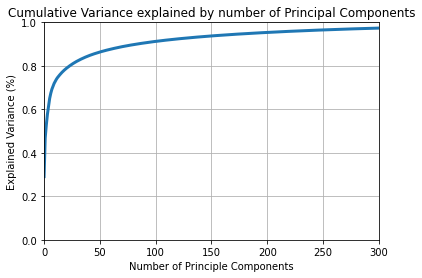

In [ ]:
# Elbow Plot
# Code here is similar to the code used in COMP5318 tutorials
# Perform PCA without specifying number of components
pca = PCA()
pca.fit(data_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance vs number of dimensions

plt.figure(figsize = (6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 300, 0, 1]) 
plt.xlabel("Number of Principle Components")
plt.ylabel("Explained Variance (%)")
plt.title("Cumulative Variance explained by number of Principal Components")
plt.grid(True)
plt.show()

Based on the elbow plot, 100 features seems like a good amount. But 95% of the variance is explained by 188 features. 

In [ ]:
print("Percentage of original data size used with 100 features:", (100/784) * 100)
print("Amount of variance (%) explained by 100 principal components :", cumsum[99]*100)
print("Percentage of original data size used with 188 features (95% variance explained):", (188/784) * 100)

Percentage of original data size used with 100 features: 12.755102040816327
Amount of variance (%) explained by 100 principal components : 91.18794202804565
Percentage of original data size used with 188 features (95% variance explained): 23.97959183673469


## Image Recomposition of PCA Data

To determine whether PCA was effective at representing the images in a lower dimensional state, we compared original images with their versions reconstructed from PCA.

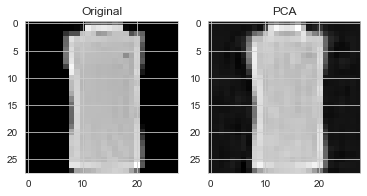

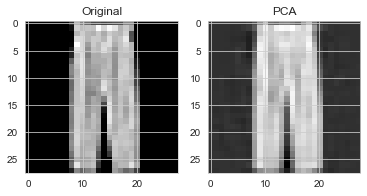

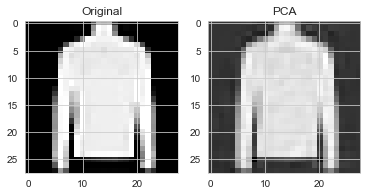

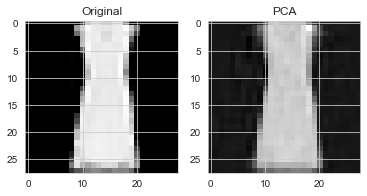

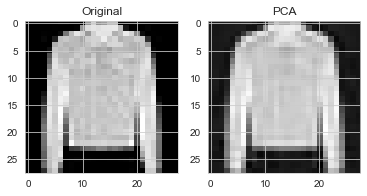

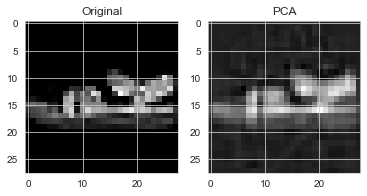

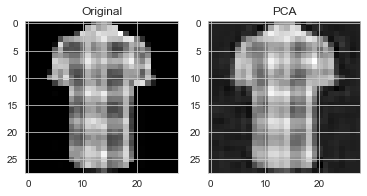

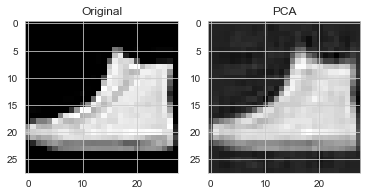

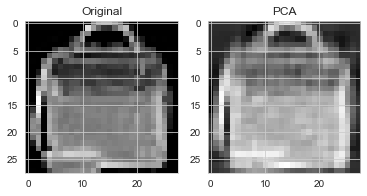

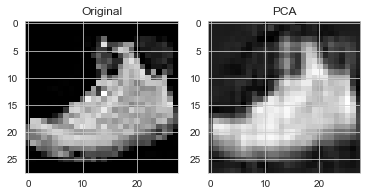

In [15]:
indices_for_plot = []
for i in range(0,10):
    _ = np.where(label_train == i)
    indices_for_plot.append(_[0][0])

pca_95 = PCA(n_components = 0.95)
pca_95_train = pca_95.fit_transform(data_train)
pca_95_inverse = pca_95.inverse_transform(pca_95_train)
pca_95_images = pca_95_inverse.reshape((data_train.shape[0], 28, 28))

for num in indices_for_plot:
    fig, (ax1,ax2) = plt.subplots(1, 2)
    ax1.imshow(data_train_plot[num], plt.get_cmap('gray'))
    ax1.set_title("Original")
    ax2.imshow(pca_95_images[num], plt.get_cmap('gray'))
    ax2.set_title("PCA")
    plt.savefig('{}image.png'.format(num))
    

PCA has removed some of the variation due to markings, changes in brightness, and even branding on the clothing. However, the overall distinctions between each class are still visible.

# <font color = "red"> 4. Preprocessing Function (run this to preprocess all data)</font>

The below function will normalise and conduct PCA on the training and test data. The PCA is fit to the training data, and then applied to the test data. 

In [6]:
def preprocess(data_train, data_test):
    # Normalise train and test pixel values to 0-100
    minmaxscale = MinMaxScaler().fit(data_train)
    data_train = minmaxscale.transform(data_train)
    data_test = minmaxscale.transform(data_test)
    
    # Run PCA for 100 components
    pca = PCA(n_components=0.95)
    pca_fit = pca.fit(data_train)
    data_train = pca_fit.transform(data_train)
    # transform test data based on training PCA
    data_test = pca_fit.transform(data_test)
    
    return data_train, data_test

data_train, data_test = preprocess(data_train, data_test)
internal_data_test = data_test[:2000]
internal_label_test = label_test

In [7]:
print(data_train.shape)
print(data_test.shape)

(30000, 188)
(5000, 188)


# <font color = "blue">5. Hyperparameter Tuning of Different Models</font>

To determine the optimal parameter combinations for a certain model, used 10-fold cross validation implemented with Scikit-learn's StratifiedKFold() and GridSearchCV() classes. 

## Hardware Used for Hyperparameter Tuning

Hyperparameter tuning is the most computationally-intensive part of training models, so a server with 12 CPUs and 30GB RAM was used:

In [8]:
print("Number of CPUs:", multiprocessing.cpu_count())
total_memory, used_memory, free_memory = map(
    int, os.popen('free -t -m').readlines()[-1].split()[1:])
print("RAM (GB):", total_memory/1000)

Number of CPUs: 12
RAM (GB): 30.091


## kNN
We tried kNN can fit linear and non-linear models depending on the value of k. Other parameters used included the type of distance to calculate (weighted or uniform), and the distance metric to use (manhattan or euclidean, corresponding to a p value of 1 and 2 respectively). 

In [8]:
# Time the hypperparameter tuning time
knn_start = time.time()
seed = 1
kNN_parameters = {'n_neighbors': [1,3,5,7,9,11], 'weights':['uniform', 'distance'], 'p':[1,2]}
kNN = KNeighborsClassifier()
kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
kNN_classifier = GridSearchCV(kNN, kNN_parameters, cv = kfold, scoring = "accuracy", n_jobs = -1)
kNN_classifier.fit(data_train, label_train)
knn_end = time.time()

The following functions were created to report on the results of hyperparameter tuning using GridSearchCV().

In [13]:
def display_GridSearch_results(filepath, num_results = 10):
    """
    Takes a filepath to a GridSearchCV results csv. 
    Prints the top 10 results by default, more can be specified.
    """
    
    results_df = pd.read_csv(filepath)
    results_df = results_df.sort_values(by=['rank_test_score'])

    # Display Fit times in minutes
    results_df['mean_fit_time'] = results_df['mean_fit_time'] /60
    results_df['std_fit_time'] = results_df['std_fit_time'] /60

    # Use in built iPython Display Function
    display(results_df[
        ['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']
    ][:num_results])

In [27]:
def display_Tuning_Results(gridsearchclassifier, name, startTime, 
                           endTime, minutes = False, hours = True, filepath = False):
    
    if minutes:
        print(f"{name} Hyperparameter Tuning Run Time (Minutes):", (endTime - startTime)/60)
    if hours:
        print(f"{name} Hyperparameter Tuning Run Time (Hours):", (endTime - startTime)/60/60)

    print(f"{name} Best Parameters:",gridsearchclassifier.best_params_)
    print(f"{name} Best Estimator:",gridsearchclassifier.best_estimator_)
    print(f"{name} Score with Best Estimator:",gridsearchclassifier.best_score_)

    if filepath:
        results = pd.DataFrame(gridsearchclassifier.cv_results_)
        results.to_csv(filepath)
        display_GridSearch_results(filepath)

In [28]:
display_Tuning_Results(kNN_classifier, name = "kNN", startTime = knn_start, 
                      endTime = knn_end, minutes = True, filepath = "kNN_GridSearchCV_results95.csv")

kNN Hyperparameter Tuning Run Time (Minutes): 11.321496645609537
kNN Hyperparameter Tuning Run Time (Hours): 0.18869161076015895
kNN Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
kNN Best Estimator: KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')
kNN Score with Best Estimator: 0.8586


,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
13,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",1,0.858600,0.006982,0.001552,0.000965
9,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",2,0.858500,0.006901,0.001023,0.000196
12,"{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}",3,0.857133,0.007003,0.001069,0.000197
17,"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",4,0.856967,0.007921,0.001126,0.000293
8,"{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}",4,0.856967,0.007689,0.001067,0.000185
19,"{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}",6,0.856233,0.005954,0.000944,0.000204
5,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}",7,0.855633,0.006903,0.000862,0.000169
15,"{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}",8,0.855567,0.006893,0.001022,0.000245
16,"{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}",9,0.855033,0.007295,0.000847,0.000114
18,"{'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}",10,0.854900,0.005758,0.001119,0.000423


In [118]:
# Helper function to assist in plotting the results over a set of parameters.
def get_param_boxplot(filepath, query, group_by, indices_list):
    df = pd.read_csv(filepath)
    _ = df.query(query)
    _ = _.iloc[:,indices_list]
    _ = _.set_index(group_by)
    return _

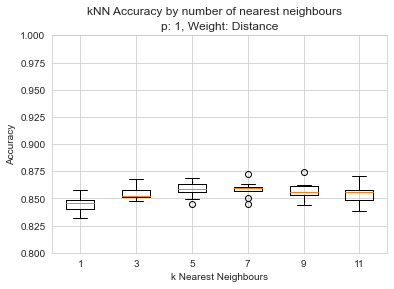

In [156]:
knn_dist_manh = get_param_boxplot(filepath ="kNN_GridSearchCV_results95.csv",
                                    query = 'param_weights == "distance" & param_p == 1',
                                    group_by ='param_n_neighbors',
                                    indices_list = [5,9,10,11,12,13,14,15,16,17,18])
plt.figure(figsize = (6,4))
plt.boxplot(knn_dist_manh.T)
plt.ylim(0.8, 1)
plt.xticks(ticks = [1,2,3,4,5,6],labels = [1,3,5,7,9,11])
plt.xlabel("k Nearest Neighbours")
plt.ylabel("Accuracy")
plt.suptitle("kNN Accuracy by number of nearest neighbours")
plt.title("p: 1, Weight: Distance")
plt.savefig('kNN_1_Distance.png')

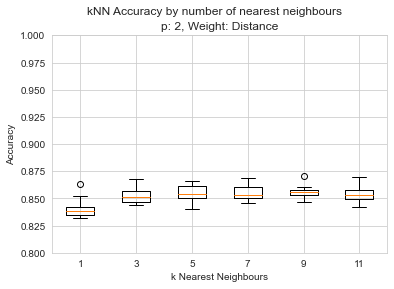

In [157]:
knn_dist_euc = get_param_boxplot(filepath ="kNN_GridSearchCV_results95.csv",
                                    query = 'param_weights == "distance" & param_p == 2',
                                    group_by ='param_n_neighbors',
                                    indices_list = [5,9,10,11,12,13,14,15,16,17,18])
plt.figure(figsize = (6,4))
plt.boxplot(knn_dist_euc.T)
plt.ylim(0.8, 1)
plt.xticks(ticks = [1,2,3,4,5,6],labels = [1,3,5,7,9,11])
plt.xlabel("k Nearest Neighbours")
plt.ylabel("Accuracy")
plt.suptitle("kNN Accuracy by number of nearest neighbours")
plt.title("p: 2, Weight: Distance")
plt.savefig('kNN_2_Distance.png')

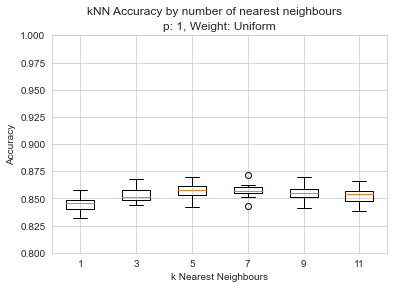

In [146]:
knn_uniform_manh = get_param_boxplot(filepath ="kNN_GridSearchCV_results95.csv",
                                    query = 'param_weights == "uniform" & param_p == 1',
                                    group_by ='param_n_neighbors',
                                    indices_list = [5,9,10,11,12,13,14,15,16,17,18])
plt.figure(figsize = (6,4))
plt.boxplot(knn_uniform_manh.T)
plt.ylim(0.8, 1)
plt.xticks(ticks = [1,2,3,4,5,6],labels = [1,3,5,7,9,11])
plt.xlabel("k Nearest Neighbours")
plt.ylabel("Accuracy")
plt.suptitle("kNN Accuracy by number of nearest neighbours")
plt.title("p: 1, Weight: Uniform")
plt.savefig('kNN_1_Uniform.png')

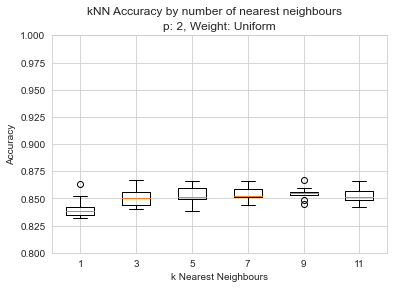

In [145]:
knn_uniform_euc = get_param_boxplot(filepath = "kNN_GridSearchCV_results95.csv", 
                                    query = 'param_weights == "uniform" & param_p == 2',
                                   group_by = 'param_n_neighbors',
                                    indices_list = [5,9,10,11,12,13,14,15,16,17,18])
plt.figure(figsize = (6,4))
plt.boxplot(knn_uniform_euc.T)
plt.ylim(0.8, 1)
plt.xticks(ticks = [1,2,3,4,5,6],labels = [1,3,5,7,9,11])
plt.xlabel("k Nearest Neighbours")
plt.ylabel("Accuracy")
plt.suptitle("kNN Accuracy by number of nearest neighbours")
plt.title("p: 2, Weight: Uniform")
plt.savefig('kNN_2_Uniform.png')

We can see from these plots that the value of k was the most important parameter. The accuracy of models with different distance metrics or weight allocations varied similarly around the k value. 

## Support Vector Machines
Given the high dimensionality of the data, SVM could be a viable algorithm. Linear and non-linear SVM algorithms will be explored. 

### Identifying the best kernel

In [16]:
seed = 1
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
accuracies = {k:[] for k in kernels}
times = {k:[] for k in kernels}
num_folds = 10
scoring = "accuracy"

In [ ]:
for k in kernels:
    svm_start = time.time()
    svm = SVC(C = 1, kernel = k, gamma = 'scale', decision_function_shape = 'ovr')
    kfold = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle=True)
    acc = cross_val_score(svm, data_train, label_train, cv=kfold, scoring = scoring, verbose= 1)
    svm_end = time.time()
    run_time = svm_end - svm_start
    accuracies[k].append(acc)
    times[k].append(run_time)

In [18]:
for k,v in accuracies.items():
    print("Kernel: {}\n Accuracy: {:.3f}".format(k,np.mean(v)))
print()
for k,v in times.items():
    print("Kernel: {}\n Time(min): {:.2f}".format(k,np.mean(v)/60))

Kernel: linear
 Accuracy: 0.858
Kernel: poly
 Accuracy: 0.877
Kernel: rbf
 Accuracy: 0.888
Kernel: sigmoid
 Accuracy: 0.695

Kernel: linear
 Time(min): 4.99
Kernel: poly
 Time(min): 5.29
Kernel: rbf
 Time(min): 5.09
Kernel: sigmoid
 Time(min): 4.51


The RBF kernel had the highest accuracy and was relatively fast. This kernel will be explored further through tuning. 

### Tuning the RBF Kernel for SVM

In [21]:
SVM_start = time.time()
seed = 1
SVM_parameters = {'gamma': ['scale', 'auto'],
                  'C': [0.1, 1, 10, 50, 100]
                 }
SVM = SVC(kernel = 'rbf', decision_function_shape = 'ovr')
kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
SVM_clf = GridSearchCV(SVM, SVM_parameters, cv = kfold, scoring = "accuracy", verbose = 1)
SVM_clf.fit(data_train,label_train)
SVM_end = time.time()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [22]:
display_Tuning_Results(SVM_clf, name = "SVM", startTime = SVM_start, 
                      endTime = SVM_end, minutes = True, hours = True, 
                       filepath = "SVM_GridSearchCV_results95.csv")

SVM Hyperparameter Tuning Run Time (Minutes): 52.81373250087102
SVM Hyperparameter Tuning Run Time (Minutes): 0.880228875014517
SVM Best Parameters: {'C': 10, 'gamma': 'scale'}
SVM Best Estimator: SVC(C=10)
SVM Score with Best Estimator: 0.8999


,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
4,"{'C': 10, 'gamma': 'scale'}",1,0.899900,0.005710,0.341759,0.002091
7,"{'C': 50, 'gamma': 'auto'}",2,0.897067,0.006912,0.306952,0.001839
6,"{'C': 50, 'gamma': 'scale'}",3,0.894767,0.008125,0.358311,0.001704
9,"{'C': 100, 'gamma': 'auto'}",4,0.893900,0.006325,0.327140,0.004226
8,"{'C': 100, 'gamma': 'scale'}",5,0.892833,0.008300,0.361105,0.002458
5,"{'C': 10, 'gamma': 'auto'}",6,0.892333,0.006984,0.288634,0.002368
2,"{'C': 1, 'gamma': 'scale'}",7,0.887800,0.007194,0.365429,0.004481
3,"{'C': 1, 'gamma': 'auto'}",8,0.871133,0.006421,0.369930,0.001606
0,"{'C': 0.1, 'gamma': 'scale'}",9,0.842600,0.007629,0.639491,0.015800
1,"{'C': 0.1, 'gamma': 'auto'}",10,0.818367,0.009365,0.683637,0.020779


It seems the best C value lies between 10 and 50, and the gamma setting is less important, so we can try values between 10 and 50 for SVM:

In [23]:
SVM_start = time.time()
seed = 1
SVM_parameters = {'gamma': ['scale', 'auto'],
                  'C': [10, 20, 30, 40, 50]
                 }
SVM = SVC(kernel = 'rbf', decision_function_shape = 'ovr')
kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
SVM_clf = GridSearchCV(SVM, SVM_parameters, cv = kfold, scoring = "accuracy", verbose = 1)
SVM_clf.fit(data_train,label_train)
SVM_end = time.time()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [29]:
display_Tuning_Results(SVM_clf, name = "SVM", startTime = SVM_start, 
                      endTime = SVM_end, minutes = True, hours = True, 
                       filepath = "SVM_GridSearchCV_results952.csv")

SVM Hyperparameter Tuning Run Time (Minutes): 45.42919369538625
SVM Hyperparameter Tuning Run Time (Hours): 0.7571532282564376
SVM Best Parameters: {'C': 10, 'gamma': 'scale'}
SVM Best Estimator: SVC(C=10)
SVM Score with Best Estimator: 0.8999


,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
0,"{'C': 10, 'gamma': 'scale'}",1,0.899900,0.005710,0.369737,0.005313
2,"{'C': 20, 'gamma': 'scale'}",2,0.897733,0.006797,0.361749,0.009079
9,"{'C': 50, 'gamma': 'auto'}",3,0.897067,0.006912,0.332903,0.020304
5,"{'C': 30, 'gamma': 'auto'}",4,0.896967,0.005330,0.313369,0.006093
7,"{'C': 40, 'gamma': 'auto'}",5,0.896867,0.006423,0.333604,0.014601
4,"{'C': 30, 'gamma': 'scale'}",6,0.896000,0.007483,0.379164,0.013300
3,"{'C': 20, 'gamma': 'auto'}",7,0.895867,0.006161,0.305278,0.007536
6,"{'C': 40, 'gamma': 'scale'}",8,0.895067,0.007180,0.366374,0.011766
8,"{'C': 50, 'gamma': 'scale'}",9,0.894767,0.008125,0.384426,0.012293
1,"{'C': 10, 'gamma': 'auto'}",10,0.892333,0.006984,0.289553,0.005697


It appears that a cost value of 10 is still best. 

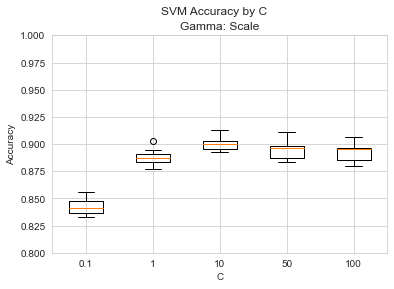

In [148]:
svm_scale_1 = get_param_boxplot(filepath = "SVM_GridSearchCV_results95.csv", 
                                    query = 'param_gamma == "scale"',
                                   group_by = 'param_C',
                                    indices_list = [5,8,9,10,11,12,13,14,15,16,17])
plt.boxplot(svm_scale_1.T)
plt.ylim(0.8, 1)
plt.xticks(ticks = [1,2,3,4,5],labels = [0.1,1,10,50,100])
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.suptitle("SVM Accuracy by C")
plt.title("Gamma: Scale")
axes[1].boxplot(svm_scale.T)
plt.savefig('SVM_Scale_1.png')

In [ ]:
svm_scale_1 = get_param_boxplot(filepath = "SVM_GridSearchCV_results95.csv", 
                                    query = 'param_gamma == "auto"',
                                   group_by = 'param_C',
                                    indices_list = [5,8,9,10,11,12,13,14,15,16,17])
plt.boxplot(svm_scale_1.T)
plt.ylim(0.8, 1)
plt.xticks(ticks = [1,2,3,4,5],labels = [0.1,1,10,50,100])
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.suptitle("SVM Accuracy by C")
plt.title("Gamma: Scale")
axes[1].boxplot(svm_scale.T)
plt.savefig('SVM_Scale_1.png')

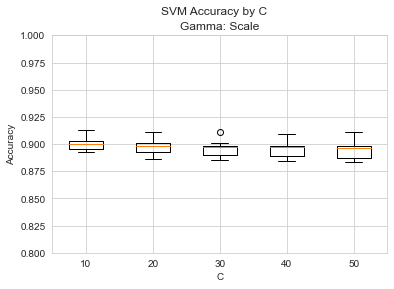

In [149]:
svm_scale = get_param_boxplot(filepath = "SVM_GridSearchCV_results952.csv", 
                                    query = 'param_gamma == "scale"',
                                   group_by = 'param_C',
                                    indices_list = [5,8,9,10,11,12,13,14,15,16,17])
plt.figure(figsize = (6,4))
plt.boxplot(svm_scale.T)
plt.ylim(0.8, 1)
plt.xticks(ticks = [1,2,3,4,5],labels = [10,20,30,40,50])
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.suptitle("SVM Accuracy by C")
plt.title("Gamma: Scale")
plt.savefig('SVM_Scale_2.png')

It appears that a cost value of 10 is still best. 

## SVM with Bagging

Based on the above results, we can try SVM with bagging, keeping the best base-estimator values. Using bagging may improve model generalisation. Given it takes approximately 0.36 minutes per fit with this model, we are limited to trying bagging with 20 estimators (approximately 7 minutes per fit). A higher number of estimators may improve accuracy but will exceed the running time limitations of this study. 

In [25]:
bagging_SVM_start = time.time()
seed = 1
bagging_SVM_grid = param_grid = {"base_estimator__kernel": ['rbf'],
                           "base_estimator__gamma": ["scale"],
                           "base_estimator__C": [10],
                           "n_estimators": [10, 20]
             }
base_SVM = SVC()
bagging_SVM = BaggingClassifier(base_estimator = base_SVM)
kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
bagging_SVM_clf = GridSearchCV(bagging_SVM, bagging_SVM_grid, cv = kfold, scoring = "accuracy", verbose = 1)
bagging_SVM_clf.fit(data_train,label_train)
bagging_SVM_end = time.time()

Fitting 10 folds for each of 2 candidates, totalling 20 fits


In [30]:
display_Tuning_Results(bagging_SVM_clf, name = "Bagging SVM", startTime = bagging_SVM_start, 
                      endTime = bagging_SVM_end, minutes = True, hours = True, 
                       filepath = "bagging_SVM_GridSearchCV_results95.csv")

Bagging SVM Hyperparameter Tuning Run Time (Minutes): 67.14757999976476
Bagging SVM Hyperparameter Tuning Run Time (Hours): 1.1191263333294126
Bagging SVM Best Parameters: {'base_estimator__C': 10, 'base_estimator__gamma': 'scale', 'base_estimator__kernel': 'rbf', 'n_estimators': 20}
Bagging SVM Best Estimator: BaggingClassifier(base_estimator=SVC(C=10), n_estimators=20)
Bagging SVM Score with Best Estimator: 0.9005333333333333


,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
1,"{'base_estimator__C': 10, 'base_estimator__gam...",1,0.900533,0.006687,2.801565,0.179912
0,"{'base_estimator__C': 10, 'base_estimator__gam...",2,0.899133,0.006450,1.429894,0.049507


## XGBoost
XGBoost is a gradient boosting algorithm for decision trees (see report for reference). It is supposed to be faster and yield better results than standard gradient boosting algorithms. 

In [ ]:
xgb_start = time.time()
seed = 1
xgb_parameters = {'objective':['multi:softmax'],
                      'num_class':[10],
                      'max_depth': [100, 50, 5, 1],
                      'n_estimators': [100, 50, 10],
                      'seed': [1]}
xgb = xgb.XGBClassifier(use_label_encoder=False)
kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
xgb_classifier = GridSearchCV(xgb, xgb_parameters, cv = kfold, scoring = "accuracy", verbose = 2)
xgb_classifier.fit(data_train, label_train)
xgb_end = time.time()

In [33]:
display_Tuning_Results(xgb_classifier, name = "XGBoost", startTime = xgb_start, 
                      endTime = xgb_end, minutes = True, hours = True, 
                       filepath = "XGB_GridSearchCV_results95.csv")

XGBoost Hyperparameter Tuning Run Time (Minutes): 224.30377303361894
XGBoost Hyperparameter Tuning Run Time (Hours): 3.7383962172269825
XGBoost Best Parameters: {'max_depth': 5, 'n_estimators': 100, 'num_class': 10, 'objective': 'multi:softmax', 'seed': 1}
XGBoost Best Estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_class=10, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
XGBoost Score with Best Estima

,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
6,"{'max_depth': 5, 'n_estimators': 100, 'num_cla...",1,0.874833,0.004954,3.023470,0.190209
0,"{'max_depth': 100, 'n_estimators': 100, 'num_c...",2,0.873767,0.006776,4.561733,0.158198
3,"{'max_depth': 50, 'n_estimators': 100, 'num_cl...",3,0.873367,0.006711,4.179353,0.357859
1,"{'max_depth': 100, 'n_estimators': 50, 'num_cl...",4,0.869700,0.006488,3.050234,0.233804
4,"{'max_depth': 50, 'n_estimators': 50, 'num_cla...",5,0.869633,0.006475,2.467208,0.027836
7,"{'max_depth': 5, 'n_estimators': 50, 'num_clas...",6,0.864667,0.005333,1.625650,0.159335
2,"{'max_depth': 100, 'n_estimators': 10, 'num_cl...",7,0.847567,0.006379,1.092283,0.122465
5,"{'max_depth': 50, 'n_estimators': 10, 'num_cla...",8,0.847500,0.006391,0.911267,0.010686
8,"{'max_depth': 5, 'n_estimators': 10, 'num_clas...",9,0.826100,0.006465,0.282628,0.005224
9,"{'max_depth': 1, 'n_estimators': 100, 'num_cla...",10,0.814233,0.006867,0.562842,0.022195


XGBoost achieved around 88% accuracy with 7 minutes or less training time. It appears that the number of estimators is the most influential parameter, but also that smaller depth trees are preferred. Thus to determine the optimal depth, GridSearchCV was run again for XGBoost with only 10 estimators, but different small max depth levels.

In [ ]:
xgb2_start = time.time()
seed = 1
xgb2_parameters = {'objective':['multi:softmax'],
                      'num_class':[10],
                      'max_depth': [2,3,4,5,6,7,8,9,10],
                      'n_estimators': [10],
                      'seed': [1]}
xgb2 = xgb.XGBClassifier(use_label_encoder=False)
kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
xgb2_classifier = GridSearchCV(xgb2, xgb2_parameters, cv = kfold, scoring = "accuracy")
xgb2_classifier.fit(data_train, label_train)
xgb2_end = time.time()

In [37]:
display_Tuning_Results(xgb2_classifier, name = "XGBoost", startTime = xgb2_start, 
                      endTime = xgb2_end, minutes = True, hours = False, 
                       filepath = "XGB_GridSearchCV_results95_smallDepth.csv")

XGBoost Hyperparameter Tuning Run Time (Minutes): 31.08124213218689
XGBoost Best Parameters: {'max_depth': 10, 'n_estimators': 10, 'num_class': 10, 'objective': 'multi:softmax', 'seed': 1}
XGBoost Best Estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=12, num_class=10, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
XGBoost Score with Best Estimator: 0.8463333333333335


,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
8,"{'max_depth': 10, 'n_estimators': 10, 'num_cla...",1,0.846333,0.007887,0.553089,0.028953
7,"{'max_depth': 9, 'n_estimators': 10, 'num_clas...",2,0.845567,0.006077,0.496195,0.003567
6,"{'max_depth': 8, 'n_estimators': 10, 'num_clas...",3,0.843467,0.006279,0.448677,0.004240
5,"{'max_depth': 7, 'n_estimators': 10, 'num_clas...",4,0.840533,0.007912,0.395975,0.010078
4,"{'max_depth': 6, 'n_estimators': 10, 'num_clas...",5,0.834833,0.007679,0.339789,0.007637
3,"{'max_depth': 5, 'n_estimators': 10, 'num_clas...",6,0.826100,0.006465,0.286973,0.007097
2,"{'max_depth': 4, 'n_estimators': 10, 'num_clas...",7,0.810867,0.006871,0.223960,0.002665
1,"{'max_depth': 3, 'n_estimators': 10, 'num_clas...",8,0.790233,0.009429,0.168974,0.007289
0,"{'max_depth': 2, 'n_estimators': 10, 'num_clas...",9,0.752200,0.008945,0.129822,0.016422


This indicated that the best depth is 10, we tried this model with a higher number of estimators:

In [ ]:
xgb2_start = time.time()
seed = 1
xgb2_parameters = {'objective':['multi:softmax'],
                      'num_class':[10],
                      'max_depth': [10],
                      'n_estimators': [200],
                      'seed': [1]}
xgb2 = xgb.XGBClassifier(use_label_encoder=False)
kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
xgb2_classifier = GridSearchCV(xgb2, xgb2_parameters, cv = kfold, scoring = "accuracy")
xgb2_classifier.fit(data_train, label_train)
xgb2_end = time.time()

In [39]:
display_Tuning_Results(xgb2_classifier, name = "XGBoost", startTime = xgb2_start, 
                      endTime = xgb2_end, minutes = True, hours = False, 
                       filepath = "XGB_GridSearchCV_results95_Depth10.csv")

XGBoost Hyperparameter Tuning Run Time (Minutes): 70.24312881628673
XGBoost Best Parameters: {'max_depth': 10, 'n_estimators': 200, 'num_class': 10, 'objective': 'multi:softmax', 'seed': 1}
XGBoost Best Estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_class=10, num_parallel_tree=1,
              objective='multi:softprob', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
XGBoost Score with Best Estimator: 0.8777333333333333


,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
0,"{'max_depth': 10, 'n_estimators': 200, 'num_cl...",1,0.877733,0.007023,6.349302,0.24875


## Logistic Regression
Logistic regression is a linear classification algorithm. For this multiclass problem, a One-vs-Rest (OVR) implementation will be used. In OVR a binary classification model is created for each class, predicting whether an example belongs to that class or not.  

In [ ]:
log_reg_start = time.time()
seed = 1
log_reg_parameters = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                     'C': [1, 10, 100],
                     'max_iter': [100, 200, 500]}
log_reg = LogisticRegression(multi_class = 'ovr')
kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
log_reg_clf = GridSearchCV(log_reg, log_reg_parameters, cv = kfold, scoring = "accuracy")
log_reg_clf.fit(data_train,label_train)
log_reg_end = time.time()

In [36]:
display_Tuning_Results(log_reg_clf, name = "Logistic Regression", startTime = log_reg_start, 
                      endTime = log_reg_end, minutes = True, hours = False, 
                      filepath = "logreg_DT_results95.csv")

Logistic Regression Hyperparameter Tuning Run Time (Minutes): 37.24619394540787
Logistic Regression Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}
Logistic Regression Best Estimator: LogisticRegression(C=1, multi_class='ovr')
Logistic Regression Score with Best Estimator: 0.8516666666666666


,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
1,"{'C': 1, 'max_iter': 100, 'penalty': 'l2'}",1,0.851667,0.008179,0.106743,0.003964
5,"{'C': 1, 'max_iter': 200, 'penalty': 'l2'}",2,0.851467,0.007863,0.181169,0.007405
9,"{'C': 1, 'max_iter': 500, 'penalty': 'l2'}",2,0.851467,0.007828,0.208846,0.005550
17,"{'C': 10, 'max_iter': 200, 'penalty': 'l2'}",4,0.851200,0.007651,0.203446,0.010683
13,"{'C': 10, 'max_iter': 100, 'penalty': 'l2'}",5,0.851100,0.007655,0.108041,0.003831
21,"{'C': 10, 'max_iter': 500, 'penalty': 'l2'}",6,0.850967,0.007502,0.304042,0.006085
29,"{'C': 100, 'max_iter': 200, 'penalty': 'l2'}",7,0.850967,0.007595,0.197954,0.015289
31,"{'C': 100, 'max_iter': 200, 'penalty': 'none'}",8,0.850900,0.007819,0.172112,0.004501
7,"{'C': 1, 'max_iter': 200, 'penalty': 'none'}",8,0.850900,0.007819,0.198793,0.005032
19,"{'C': 10, 'max_iter': 200, 'penalty': 'none'}",8,0.850900,0.007819,0.195976,0.007477


The l2 penalty and C value of 1 appeared to perform best, subsequently different solvers were tested using a second GridSearchCV:

In [ ]:
# L2 performed better than L1 penalty. Further tuning with solvers to see if there is any improvement
log_reg_start_l2 = time.time()
seed = 1
log_reg_l2_parameters = {'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
                     'C': [1],
                     'max_iter': [1000]}
log_reg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'ovr')
kfold = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
log_reg_l2_clf = GridSearchCV(log_reg_l2, log_reg_l2_parameters, cv = kfold, scoring = "accuracy", verbose = 2)
log_reg_l2_clf.fit(data_train,label_train)
log_reg_l2_end = time.time()

In [44]:
display_Tuning_Results(log_reg_l2_clf, name = "Logistic Regression l2", startTime = log_reg_start_l2, 
                      endTime = log_reg_l2_end, minutes = True, hours = False, 
                      filepath = "logreg_l2_results95.csv")

Logistic Regression l2 Hyperparameter Tuning Run Time (Minutes): 138.880205198129
Logistic Regression l2 Best Parameters: {'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}
Logistic Regression l2 Best Estimator: LogisticRegression(C=1, max_iter=1000, multi_class='ovr')
Logistic Regression l2 Score with Best Estimator: 0.8514666666666667


,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
1,"{'C': 1, 'max_iter': 1000, 'solver': 'lbfgs'}",1,0.851467,0.007928,0.205878,0.003481
2,"{'C': 1, 'max_iter': 1000, 'solver': 'newton-cg'}",1,0.851467,0.007828,0.211479,0.019369
3,"{'C': 1, 'max_iter': 1000, 'solver': 'sag'}",3,0.851233,0.007659,5.811366,0.249526
4,"{'C': 1, 'max_iter': 1000, 'solver': 'saga'}",4,0.851033,0.007920,7.074606,0.358860
0,"{'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}",5,0.850133,0.007308,0.561274,0.027070


## Adaboost Decision Tree


The theory of adaboost is that it can boost a set of weak learners to be a very strong ensemble learner. So in this experiment, we tried adaboost with decision tree stumps (max depth of either 1, 2, or 3), with a high number of estimators (500, 1000, 2000). 

In [ ]:
adaboost_DT_start = time.time()
adaboost_DT_grid = param_grid = {"base_estimator__max_depth": [1,2],
                           "base_estimator__criterion": ["gini", "entropy"],
                           "n_estimators": [10, 50, 100, 150]
             }
base_DT = DecisionTreeClassifier()
adaboost_DT = AdaBoostClassifier(base_estimator = base_DT)
kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle=True)
bagging_DT_clf = GridSearchCV(adaboost_DT, adaboost_DT_grid, cv = kfold, scoring = "accuracy", verbose = 2)
bagging_DT_clf.fit(data_train,label_train)
bagging_DT_end = time.time()

In [32]:
display_Tuning_Results(bagging_DT_clf, name = "Adaboost Decision Tree", startTime = adaboost_DT_start, 
                      endTime = bagging_DT_end, minutes = True, hours = True, 
                      filepath = "adaboost_DT_results95.csv")

Adaboost Decision Tree Hyperparameter Tuning Run Time (Minutes): 568.6044361829757
Adaboost Decision Tree Hyperparameter Tuning Run Time (Hours): 9.476740603049596
Adaboost Decision Tree Best Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 2, 'n_estimators': 10}
Adaboost Decision Tree Best Estimator: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=10)
Adaboost Decision Tree Score with Best Estimator: 0.5905333333333334


,params,rank_test_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
4,"{'base_estimator__criterion': 'gini', 'base_es...",1,0.590533,0.026416,0.223510,0.001437
15,"{'base_estimator__criterion': 'entropy', 'base...",2,0.570767,0.019918,15.415741,0.449984
5,"{'base_estimator__criterion': 'gini', 'base_es...",3,0.566867,0.025742,1.119809,0.003091
7,"{'base_estimator__criterion': 'gini', 'base_es...",4,0.557067,0.033257,3.358936,0.005753
6,"{'base_estimator__criterion': 'gini', 'base_es...",5,0.549133,0.036161,2.239905,0.005388
14,"{'base_estimator__criterion': 'entropy', 'base...",6,0.547500,0.014142,9.853502,0.227263
0,"{'base_estimator__criterion': 'gini', 'base_es...",7,0.528100,0.024953,0.116624,0.001010
9,"{'base_estimator__criterion': 'entropy', 'base...",8,0.526300,0.017946,2.452721,0.005458
1,"{'base_estimator__criterion': 'gini', 'base_es...",9,0.523833,0.015961,0.576951,0.005813
11,"{'base_estimator__criterion': 'entropy', 'base...",10,0.522433,0.016117,7.359698,0.015360


# <font color = "blue"> 6. Evaluating the best candidate models from hyperparameter tuning </font>

The training and testing of the best candidate models was done on Colab using the standard CPU runtime. 

The best classifiers from hyperparameter tuning are defined below:

In [54]:
bestCandidates = {
    'kNN': KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'),
    'Logistic Regression': LogisticRegression(C=1, multi_class='ovr', solver='liblinear', penalty='l2'),
    'Support Vector Machine': SVC(C=10, gamma = 'scale', kernel = 'rbf'),
    'Bagging SVM': BaggingClassifier(base_estimator = SVC(C=10, gamma = 'scale', kernel = 'rbf'), n_estimators = 20),
    'Adaboost DT': AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 2, criterion = "gini"),
                                     n_estimators = 10)
}

In [79]:
trainingTimesDict = dict()
testingTimesDict = dict()
accuracyDict = dict()
confusionMatrices = dict()
for name in bestCandidates:
    
    model = bestCandidates[name]
    
    # fit the model on the entire training set
    fitTimeStart = time.time()
    model.fit(data_train, label_train)
    fitTimeEnd = time.time()
    trainingTimesDict[name] = fitTimeEnd - fitTimeStart
    
    # Evaluate on the testing set (internal set of 2000 samples with labels)
    testTimeStart = time.time()
    predictions = model.predict(internal_data_test)
    testTimeEnd = time.time()
    testingTimesDict[name] = testTimeEnd - testTimeStart
    # Get Accuracy
    accuracy = accuracy_score(internal_label_test, predictions)
    accuracyDict[name] = accuracy
    # Create confusion matrix
    confusionMatrices[name] = confusion_matrix(internal_label_test, predictions)
    

Due to a strange namespace conflict, the XGBoost model was defined in a separate cell and run below:

In [80]:
xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              learning_rate=0.300000012, max_depth=10,
              min_child_weight=1, n_estimators=200, num_class=10,
              objective='multi:softprob', random_state=1, seed=1,
              tree_method='exact', use_label_encoder=False)

# fit the model on the entire training set
fitTimeStart = time.time()
xgb.fit(data_train, label_train)
fitTimeEnd = time.time()
trainingTimesDict['XGBoost'] = fitTimeEnd - fitTimeStart

# Evaluate on the testing set (internal set of 2000 samples with labels)
testTimeStart = time.time()
predictions = xgb.predict(internal_data_test)
testTimeEnd = time.time()
testingTimesDict['XGBoost'] = testTimeEnd - testTimeStart
# Get metrics
accuracy = accuracy_score(internal_label_test, predictions)
accuracyDict['XGBoost'] = accuracy
# Create confusion matrix
confusionMatrices['XGBoost'] = confusion_matrix(internal_label_test, predictions)

[10:20:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Comparing Test Set Results

The below functions were created to aid in visualising the test set performance of each model.

In [81]:
def printResults(accDict, trainDict, testDict):
    df = pd.DataFrame([accDict, trainDict, testDict]).T
    df.columns = ['Accuracy', 'Training Time (s)', 'Testing Time (s)']
    display(df)

def plotResults(resultsDict, xlab, ylab, title, ylim = None):
    sns.set(font_scale = 1.1)
    modelNames = {"Support Vector Machine": "SVM"}
    xlabels = [modelNames[l] if l in modelNames else l for l in list(resultsDict.keys())]
    scatter, ax = plt.subplots(figsize = (10, 7))
    ax = sns.barplot(x=xlabels, 
                     y=list(resultsDict.values()))
    ax.set_ylabel(ylab, fontsize = 15)
    ax.set_xlabel (xlab, fontsize = 15)
    ax.set_title(title, fontsize = 18)
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

In [82]:
printResults(accuracyDict, trainingTimesDict, testingTimesDict)

,Accuracy,Training Time (s),Testing Time (s)
kNN,0.8405,0.012878,16.727357
Logistic Regression,0.8345,41.470443,0.002287
Support Vector Machine,0.8885,25.390633,4.693844
Bagging SVM,0.8880,210.839992,68.214158
Adaboost DT,0.5700,15.400326,0.006086
XGBoost,0.8675,423.000436,0.022516


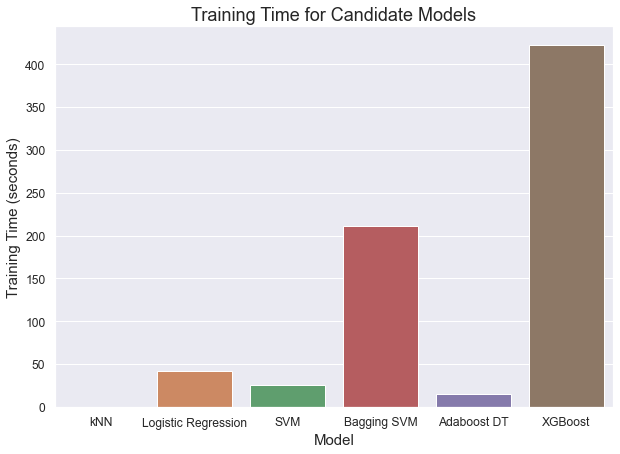

In [83]:
plotResults(trainingTimesDict, "Model", "Training Time (seconds)",
           "Training Time for Candidate Models")

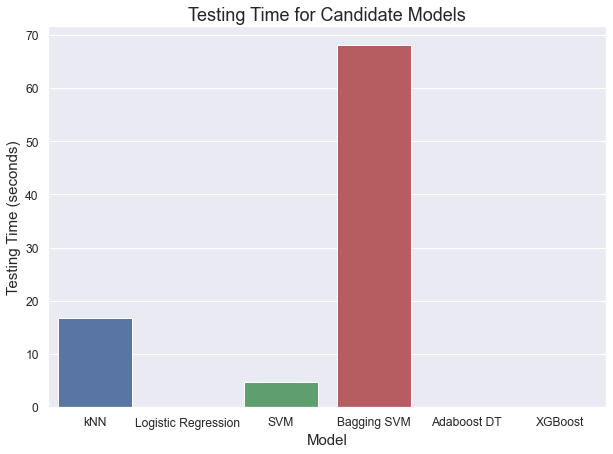

In [84]:
plotResults(testingTimesDict, "Model", "Testing Time (seconds)",
           "Testing Time for Candidate Models")

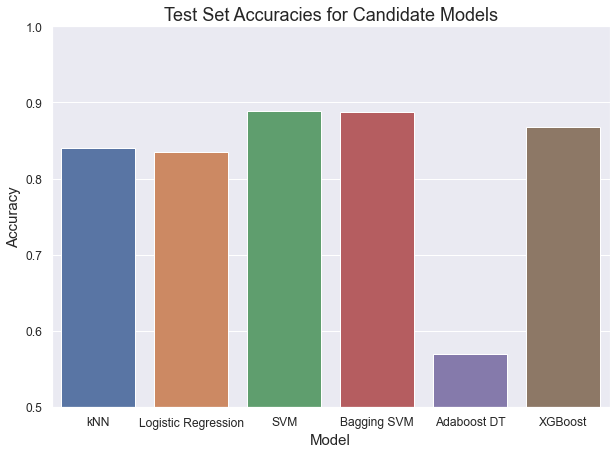

In [89]:
plotResults(accuracyDict, "Model", "Accuracy",
           "Test Set Accuracies for Candidate Models", ylim = (0.5, 1.0))

To examine the performance of each model in a class-wise manner, we created confusion matrices of the test set results: 

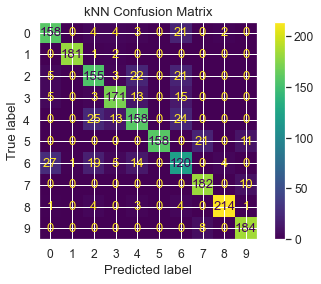

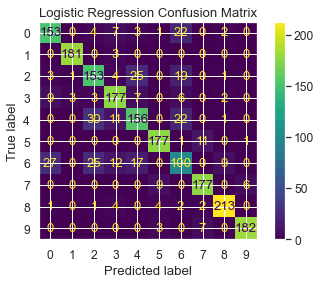

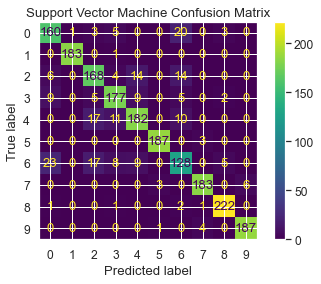

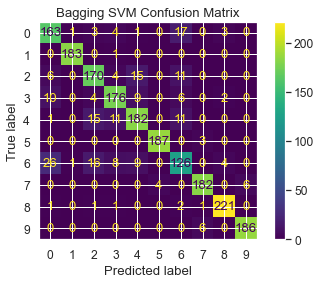

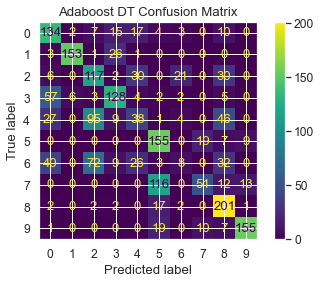

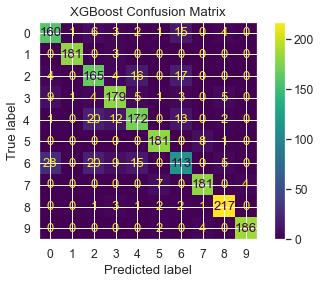

In [87]:
for model in confusionMatrices:
    cm = confusionMatrices[model]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() 
    disp.ax_.set_title(f"{model} Confusion Matrix")

It appears the majority of misclassifications were made with clothing item number 6 (shirt) being predicted as 2 (pullover),3 (dress), 4 (coat), or 0 (t-shirt/top). This is not surprising given these items of clothing can appear similar. 

# <font color = "red"> 7. Creating Output <font>

## Hardware specifications

This code was run on a standard Colab CPU runtime, the training and evaluation times reported below should be similar, however the exact instance allocated by Colab cannot be guaranteed.

The best model according to the test set is the SVM classifier with C value 10, RBF kernel, and gamma value scaled to the number of features. This model is also fast to train and test, taking on the order of tens of seconds for both. 

In [92]:
# This is the set of predictions on the entire test set from the best model
# (first should determine best model on the labelled subset of 2000 images from the test set)
# THIS SHOULD BE THE LAST THING DONE WHEN THE MODEL IS CHOSEN FOR SUBMISSION

best_model = SVC(C=10, gamma = 'scale', kernel = 'rbf')
# fit the model on the entire training set
fitTimeStart = time.time()
best_model.fit(data_train, label_train)
fitTimeEnd = time.time()
print(f"Training Time for Best Model (SVM): {fitTimeEnd-fitTimeStart} seconds")

# Evaluate on the testing set (internal set of 2000 samples with labels)
testTimeStart = time.time()
output = best_model.predict(data_test)
testTimeEnd = time.time()
print(f"Testing (5000 images) Time for Best Model (SVM): {testTimeEnd-testTimeStart} seconds")
output.shape

with h5py.File('Output/predicted_labels.h5','w') as H:
    H.create_dataset('Output',data=output)


Training Time for Best Model (SVM): 25.917442798614502 seconds
Testing (5000 images) Time for Best Model (SVM): 11.373500108718872 seconds


In [97]:
# Sanity check that predictions were saved correctly
with h5py.File('Output/predicted_labels.h5','r') as H:
    final_predictions = np.copy(H['Output'])
print(final_predictions[:10])
print(len(final_predictions))

[1 8 1 8 4 0 6 5 3 1]
5000


In [98]:
accuracy_score(output[:2000], internal_label_test)

0.8885